FOMC statements - NLP

In [2]:
# pip install pandas nltk scikit-learn textblob
# pip install vaderSentiment
# pip install spacy
# pip install bertopic
# pip install ipywidgets
# pip install transformers torch

Sentiment Analysis

In [4]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('communications.csv')

df.head()

,Date,Release Date,Type,Text
0,2024-11-07,2024-11-26,Minute,Minutes of the Federal Open Market Committee\n...
1,2024-11-07,2024-11-07,Statement,Recent indicators suggest that economic activi...
2,2024-09-18,2024-09-18,Statement,Recent indicators suggest that economic activi...
3,2024-09-18,2024-10-09,Minute,Minutes of the Federal Open Market Committee\n...
4,2024-07-31,2024-08-21,Minute,Minutes of the Federal Open Market Committee\n...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          442 non-null    object
 1   Release Date  413 non-null    object
 2   Type          442 non-null    object
 3   Text          442 non-null    object
dtypes: object(4)
memory usage: 13.9+ KB


In [6]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort DataFrame by 'Date' in ascending order
df = df.sort_values(by='Date', ascending=True)

# Display the first few rows of the sorted DataFrame
df.head()

,Date,Release Date,Type,Text
441,2000-02-02,2000-02-02,Statement,The Federal Open Market Committee voted today ...
440,2000-02-02,2000-03-23,Minute,Minutes of the Federal Open Market Committee\n...
438,2000-03-21,2000-05-18,Minute,Minutes of the Federal Open Market Committee\n...
439,2000-03-21,2000-03-21,Statement,The Federal Open Market Committee voted today ...
436,2000-05-16,2000-06-29,Minute,Minutes of the Federal Open Market Committee\n...


In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['Sentiment Score'] = df['Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['Sentiment Category'] = df['Sentiment Score'].apply(
    lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral'
)

# check
df.head()

,Date,Release Date,Type,Text,Sentiment Score,Sentiment Category
441,2000-02-02,2000-02-02,Statement,The Federal Open Market Committee voted today ...,0.8555,Positive
440,2000-02-02,2000-03-23,Minute,Minutes of the Federal Open Market Committee\n...,1.0000,Positive
438,2000-03-21,2000-05-18,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive
439,2000-03-21,2000-03-21,Statement,The Federal Open Market Committee voted today ...,0.7783,Positive
436,2000-05-16,2000-06-29,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive


In [8]:
# Get the distribution of values in the 'Sentiment Category' column
sentiment_distribution = df['Sentiment Category'].value_counts()

# Display the distribution
print(sentiment_distribution)

Sentiment Category
Positive    420
Negative     17
Neutral       5
Name: count, dtype: int64


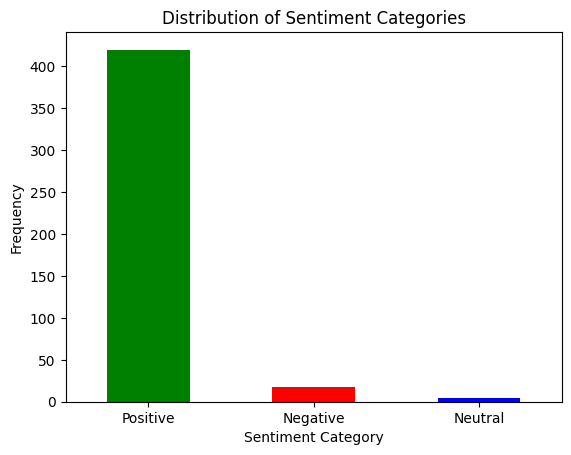

In [9]:
import matplotlib.pyplot as plt

# Plot the distribution as a bar chart
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

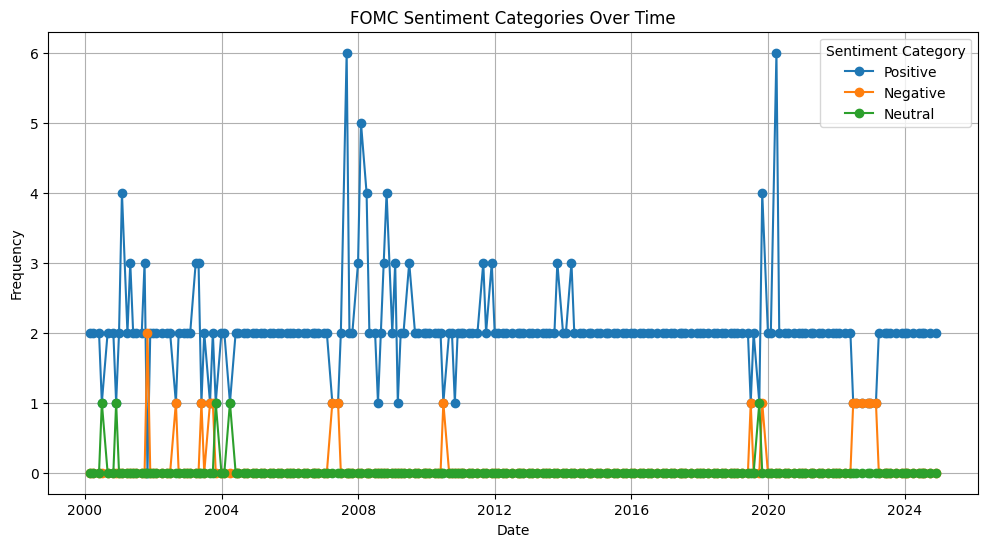

In [10]:
# FOMC Sentiment Categories Over Time

# Resample data by time (monthly in this case) and count sentiment categories
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is datetime
sentiment_trend = df.resample('ME', on='Date')['Sentiment Category'].value_counts().unstack(fill_value=0)

# Plot sentiment category trends over time
plt.figure(figsize=(12, 6))

for category in ['Positive', 'Negative', 'Neutral']:
    plt.plot(sentiment_trend.index, sentiment_trend[category], marker='o', label=category)

# Add plot titles and labels
plt.title('FOMC Sentiment Categories Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend(title='Sentiment Category')
plt.grid(True)

plt.show()

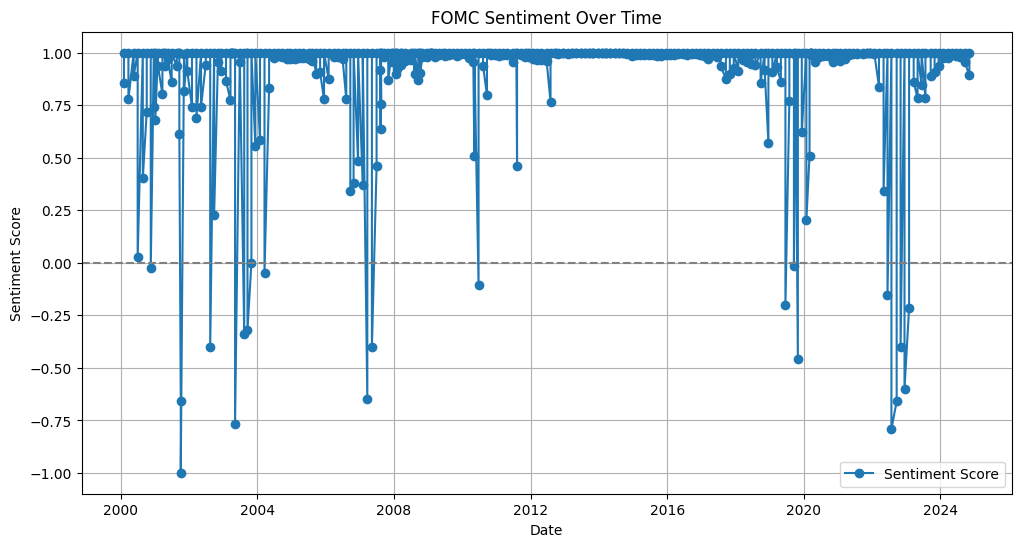

In [11]:
# Plot sentiment over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Sentiment Score'], label='Sentiment Score', marker='o')
plt.axhline(0, color='gray', linestyle='--')  # Neutral line
plt.title('FOMC Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# FinBERT sentiment analysis

from transformers import pipeline

# Load FinBERT's sentiment analysis pipeline
finbert = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

# Apply sentiment analysis
def analyze_with_finbert(text):
    if not text or len(text.strip()) == 0:
        return {'label': 'Neutral', 'score': 0.0}  # Handle empty or invalid input
    try:
        result = finbert(text[:512])  # Truncate to max model input size
        return result[0]
    except Exception as e:
        print(f"Error processing text: {text[:30]}... - {str(e)}")
        return {'label': 'Neutral', 'score': 0.0}

# Apply to the dataframe
df['FinBERT Sentiment'] = df['Text'].apply(lambda x: analyze_with_finbert(x)['label'])
df['FinBERT Score'] = df['Text'].apply(lambda x: analyze_with_finbert(x)['score'])

# Compare FinBERT sentiment with VADER
df[['Text', 'Sentiment Score', 'Sentiment Category', 'FinBERT Sentiment', 'FinBERT Score']].head()


,Text,Sentiment Score,Sentiment Category,FinBERT Sentiment,FinBERT Score
441,The Federal Open Market Committee voted today ...,0.8555,Positive,Negative,0.999991
440,Minutes of the Federal Open Market Committee\n...,1.0000,Positive,Neutral,0.999991
438,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999984
439,The Federal Open Market Committee voted today ...,0.7783,Positive,Negative,0.999998
436,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999983


In [13]:
# Get the distribution of values in the 'Sentiment Category' column
sentiment_distribution2 = df['FinBERT Sentiment'].value_counts()

# Display the distribution
print(sentiment_distribution2)

FinBERT Sentiment
Neutral     243
Negative    107
Positive     92
Name: count, dtype: int64


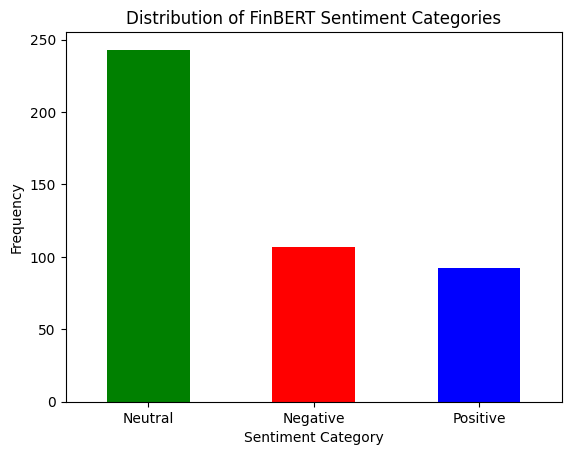

In [14]:
import matplotlib.pyplot as plt

# Plot the distribution as a bar chart
sentiment_distribution2.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of FinBERT Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

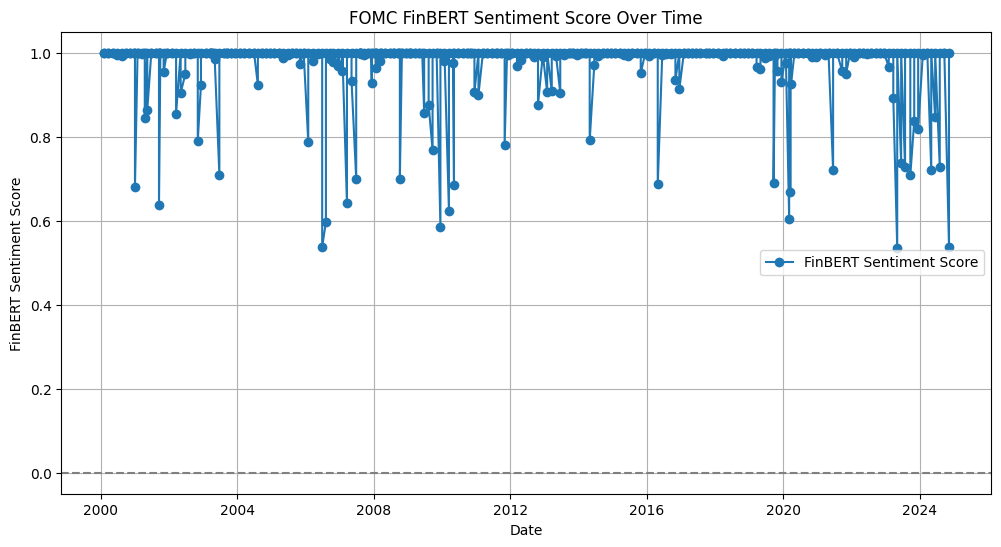

In [15]:
# Plot FinBERT sentiment score over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['FinBERT Score'], label='FinBERT Sentiment Score', marker='o')
plt.axhline(0, color='gray', linestyle='--')  # Neutral line
plt.title('FOMC FinBERT Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('FinBERT Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

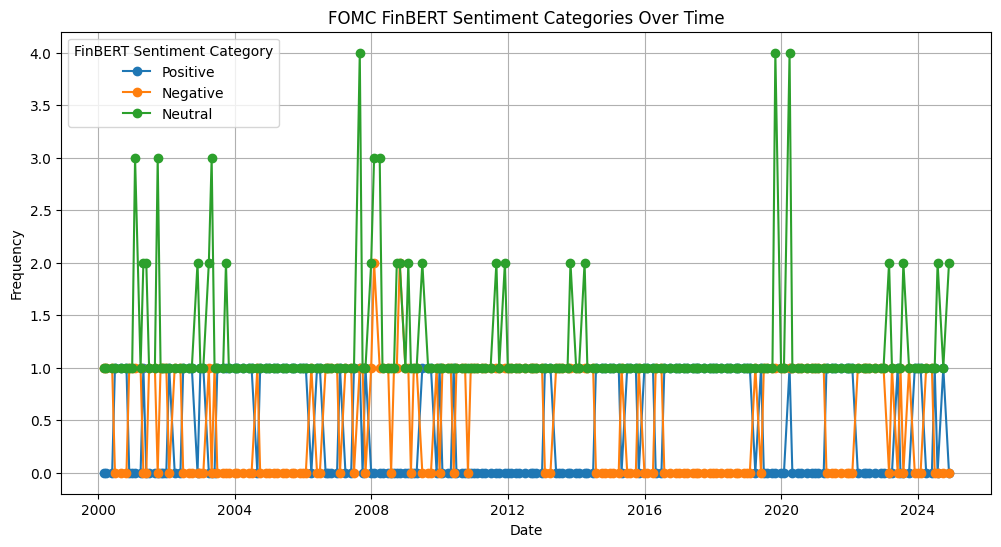

In [16]:
# FOMC Sentiment Categories Over Time

# Resample data by time (monthly in this case) and count sentiment categories
# df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is datetime
sentiment_trend = df.resample('ME', on='Date')['FinBERT Sentiment'].value_counts().unstack(fill_value=0)

# Plot sentiment category trends over time
plt.figure(figsize=(12, 6))

for category in ['Positive', 'Negative', 'Neutral']:
    plt.plot(sentiment_trend.index, sentiment_trend[category], marker='o', label=category)

# Add plot titles and labels
plt.title('FOMC FinBERT Sentiment Categories Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend(title='FinBERT Sentiment Category')
plt.grid(True)

plt.show()

In [17]:
# Average Sentiment Score
df['Average Sentiment Score'] = (df['Sentiment Score'] + df['FinBERT Score']) / 2
df[['Average Sentiment Score', 'Sentiment Score', 'FinBERT Score']].head()

,Average Sentiment Score,Sentiment Score,FinBERT Score
441,0.927746,0.8555,0.999991
440,0.999995,1.0000,0.999991
438,0.999942,0.9999,0.999984
439,0.889149,0.7783,0.999998
436,0.999942,0.9999,0.999983


In [18]:
# Keyword Extraction
# Keyword Frequency - Define lists of hawkish and dovish keywords

hawkish_keywords = [
    'tightening', 'inflation', 'rate hike', 'restrictive', 'interest rate increase',
    'monetary policy tightening', 'overheating', 'constraining', 'hawkish', 'discipline'
]

dovish_keywords = [
    'easing', 'accommodative', 'supportive', 'stimulation', 'interest rate cut',
    'monetary policy easing', 'softening', 'expansionary', 'stimulus', 'dovish'
]

# Keyword frequency function
def count_keywords(text, keywords):
    return sum(text.lower().count(word) for word in keywords)

# Add keyword frequency columns
df['Hawkish_Count'] = df['Text'].apply(lambda x: count_keywords(x, hawkish_keywords))
df['Dovish_Count'] = df['Text'].apply(lambda x: count_keywords(x, dovish_keywords))
df['Hawkish_to_Dovish_Ratio'] = df['Hawkish_Count'] / (df['Dovish_Count'] + 1)  # Prevent division by zero

df.head()

,Date,Release Date,Type,Text,Sentiment Score,Sentiment Category,FinBERT Sentiment,FinBERT Score,Average Sentiment Score,Hawkish_Count,Dovish_Count,Hawkish_to_Dovish_Ratio
441,2000-02-02,2000-02-02,Statement,The Federal Open Market Committee voted today ...,0.8555,Positive,Negative,0.999991,0.927746,2,0,2.000000
440,2000-02-02,2000-03-23,Minute,Minutes of the Federal Open Market Committee\n...,1.0000,Positive,Neutral,0.999991,0.999995,41,6,5.857143
438,2000-03-21,2000-05-18,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999984,0.999942,31,5,5.166667
439,2000-03-21,2000-03-21,Statement,The Federal Open Market Committee voted today ...,0.7783,Positive,Negative,0.999998,0.889149,2,0,2.000000
436,2000-05-16,2000-06-29,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999983,0.999942,29,7,3.625000


In [19]:
# Weighted Keywords: Assign weights to keywords based on their relative importance or frequency in the context of FOMC statements.

hawkish_keywords_weighted = {'tightening': 2, 'inflation': 3, 'rate hike': 1, 'restrictive': 2}

def count_weighted_keywords(text, keyword_dict):
    if not text:
        return 0
    return sum(text.lower().count(word) * weight for word, weight in keyword_dict.items())

df['Hawkish_Weighted_Count'] = df['Text'].fillna('').apply(lambda x: count_weighted_keywords(x, hawkish_keywords_weighted))

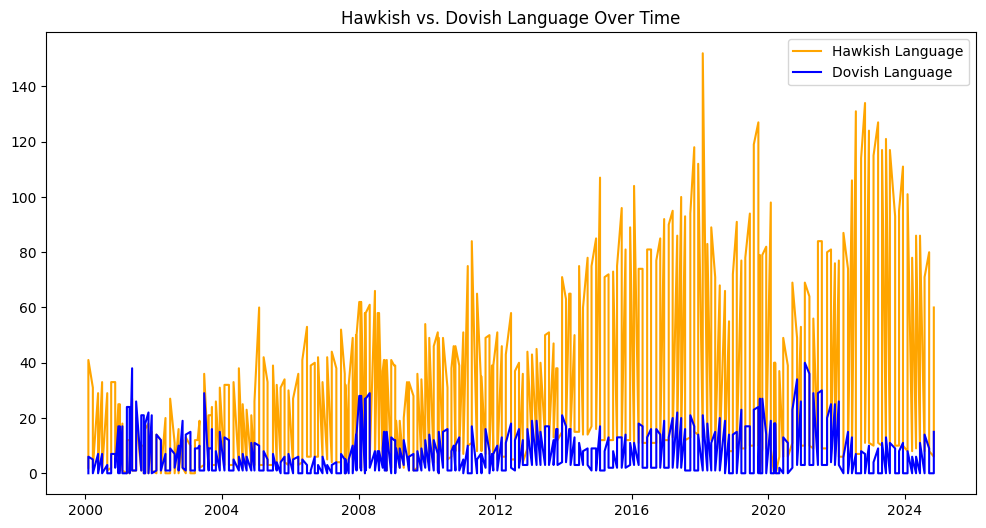

In [20]:
# Hawkish vs. Dovish Language Over Time

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Hawkish_Count'], label='Hawkish Language', color='orange')
plt.plot(df['Date'], df['Dovish_Count'], label='Dovish Language', color='blue')
# plt.plot(df['Date'], df['Hawkish_Weighted_Count'], label='Hawkish_Weighted_Count', color='green')
plt.legend()
plt.title('Hawkish vs. Dovish Language Over Time')
plt.show()

In [21]:
# Topic Modeling Using BERTopic
# Use BERTopic for identifying key topics in FOMC statements.

from bertopic import BERTopic

# Fit BERTopic on the 'Text' data
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['Text'])

# Add topic information to the dataframe
df['Topic'] = topics
df['Topic_Probabilities'] = probs

# Extract the top topic trends over time
topic_trends = df.groupby(['Date', 'Topic']).size().unstack(fill_value=0)

df.head()

,Date,Release Date,Type,Text,Sentiment Score,Sentiment Category,FinBERT Sentiment,FinBERT Score,Average Sentiment Score,Hawkish_Count,Dovish_Count,Hawkish_to_Dovish_Ratio,Hawkish_Weighted_Count,Topic,Topic_Probabilities
441,2000-02-02,2000-02-02,Statement,The Federal Open Market Committee voted today ...,0.8555,Positive,Negative,0.999991,0.927746,2,0,2.000000,6,14,1.000000
440,2000-02-02,2000-03-23,Minute,Minutes of the Federal Open Market Committee\n...,1.0000,Positive,Neutral,0.999991,0.999995,41,6,5.857143,117,4,0.196701
438,2000-03-21,2000-05-18,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999984,0.999942,31,5,5.166667,85,4,0.195990
439,2000-03-21,2000-03-21,Statement,The Federal Open Market Committee voted today ...,0.7783,Positive,Negative,0.999998,0.889149,2,0,2.000000,6,14,0.915259
436,2000-05-16,2000-06-29,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999983,0.999942,29,7,3.625000,75,4,0.186423


In [22]:
# Calculate the length of each statement
df['Text_Length'] = df['Text'].apply(len)

# Alternatively, count words instead of characters
df['Word_Count'] = df['Text'].apply(lambda x: len(x.split()))

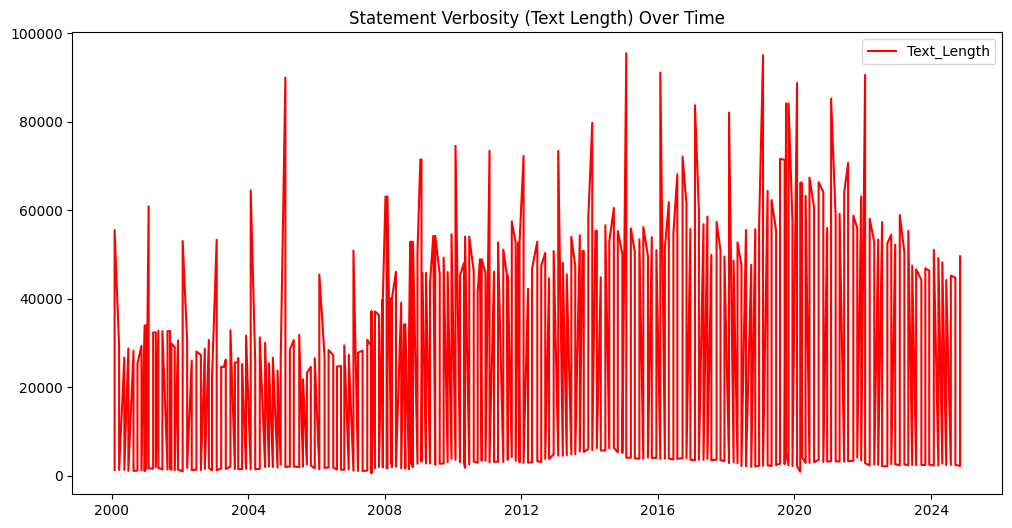

In [23]:
# Statement Verbosity (Text Length) Over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Text_Length'], label='Text_Length', color='red')
plt.legend()
plt.title('Statement Verbosity (Text Length) Over Time')
plt.show()

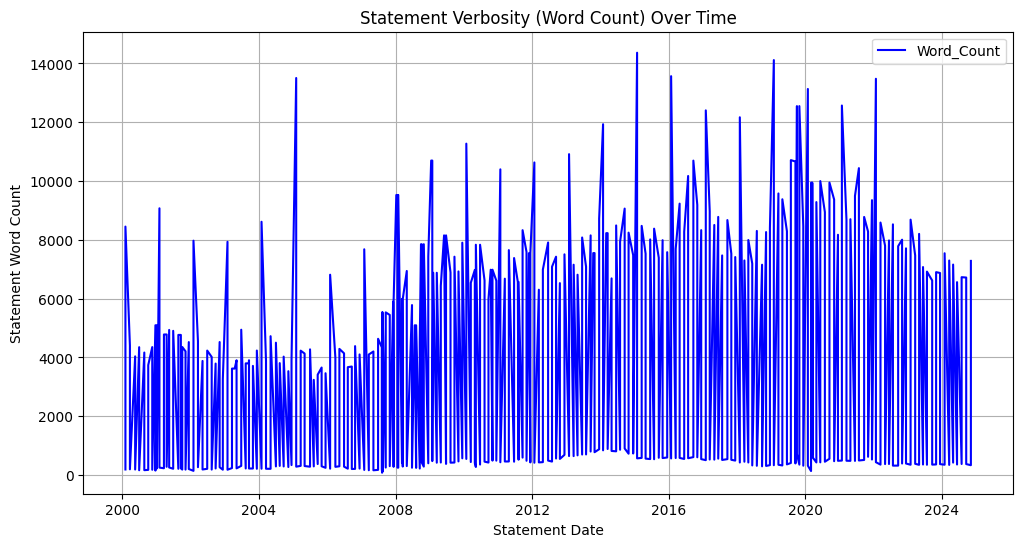

In [24]:
# Statement Verbosity (Word Count) Over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Word_Count'], label='Word_Count', color='blue')
plt.legend()
plt.title('Statement Verbosity (Word Count) Over Time')
plt.xlabel('Statement Date')
plt.ylabel('Statement Word Count')
plt.grid(True)
plt.show()

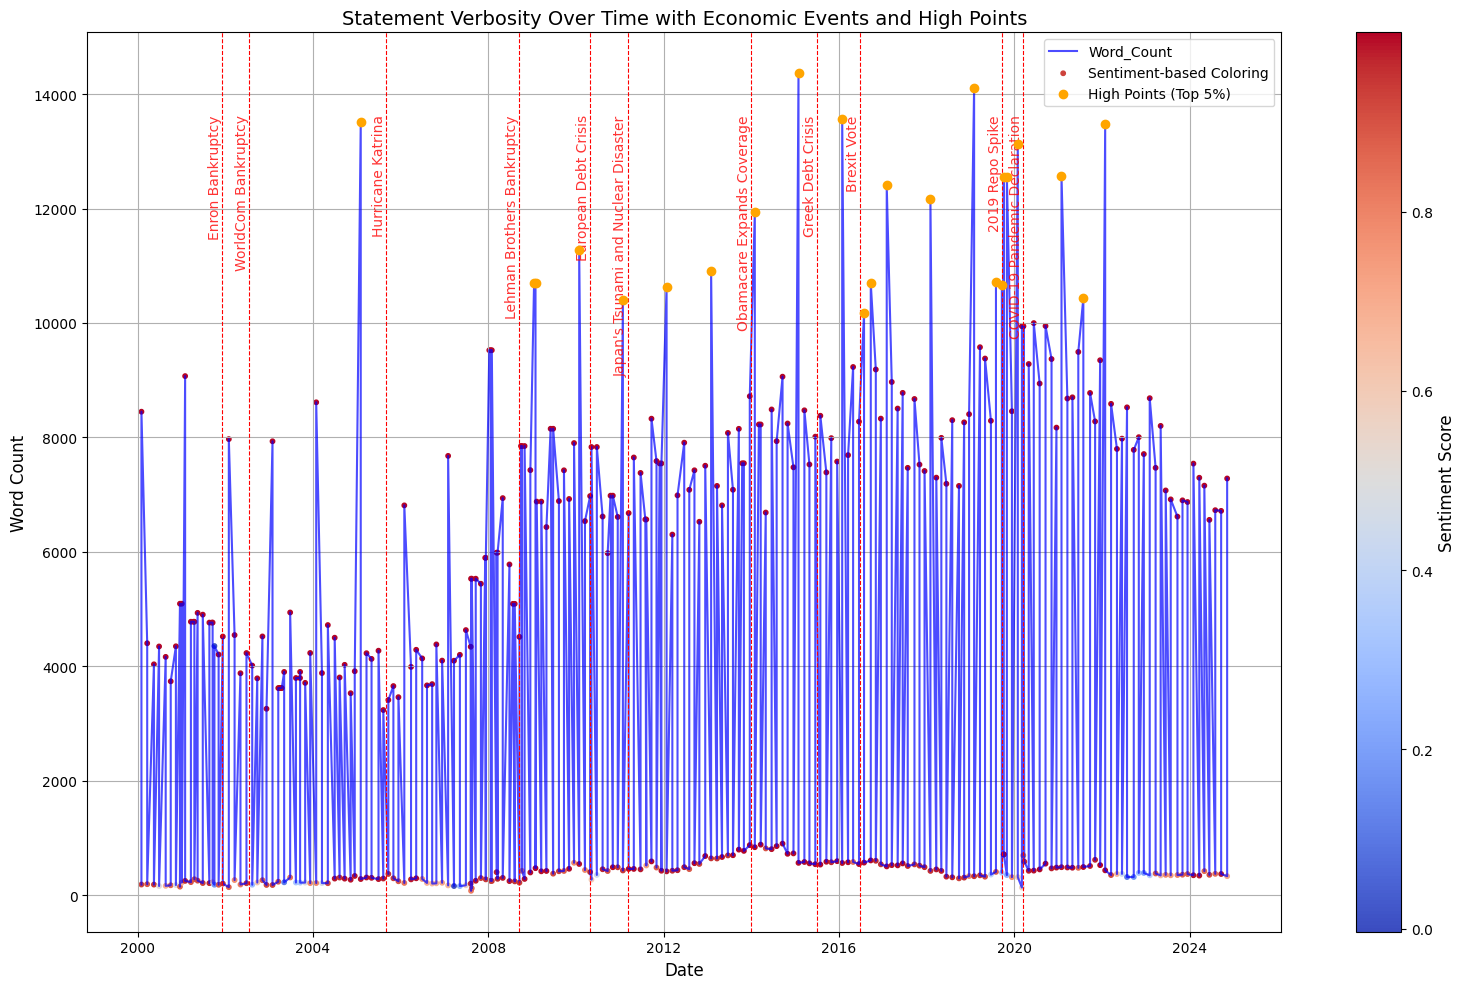

In [25]:
import matplotlib.colors as mcolors

# Normalize sentiment scores
norm = mcolors.Normalize(vmin=df['Average Sentiment Score'].min(), vmax=df['Average Sentiment Score'].max())
cmap = plt.cm.coolwarm

# Start a single figure
fig, ax = plt.subplots(figsize=(16, 10))

# Plot Word_Count over time
ax.plot(df['Date'], df['Word_Count'], label='Word_Count', color='blue', alpha=0.7)

# Add color-coded scatter points based on sentiment
colors = cmap(norm(df['Average Sentiment Score']))
ax.scatter(df['Date'], df['Word_Count'], color=colors, label='Sentiment-based Coloring', s=10)

# Highlight high points
high_point_threshold = df['Word_Count'].quantile(0.95)
df['High_Point'] = df['Word_Count'] > high_point_threshold
ax.scatter(df.loc[df['High_Point'], 'Date'], 
           df.loc[df['High_Point'], 'Word_Count'], 
           color='orange', label='High Points (Top 5%)', zorder=5)

# Add vertical lines and labels for economic events
economic_events = {
    '2001-12-02': 'Enron Bankruptcy',
    '2002-07-21': 'WorldCom Bankruptcy',
    '2005-08-29': 'Hurricane Katrina',
    '2008-09-15': 'Lehman Brothers Bankruptcy',
    '2010-05-01': 'European Debt Crisis',
    '2011-03-11': 'Japan\'s Tsunami and Nuclear Disaster',
    '2014-01-01': 'Obamacare Expands Coverage',
    '2015-07-01': 'Greek Debt Crisis',
    '2016-06-23': 'Brexit Vote',
    '2019-09-17': '2019 Repo Spike',
    '2020-03-11': 'COVID-19 Pandemic Declaration'
}
y_position = df['Word_Count'].max() * 0.95
for event_date, event_name in economic_events.items():
    event_date_parsed = pd.to_datetime(event_date)
    ax.axvline(event_date_parsed, color='red', linestyle='--', linewidth=0.8)
    ax.text(event_date_parsed, 
            y_position,  # Dynamic position below the max
            event_name, rotation=90, color='red', fontsize=10, alpha=0.8, ha='right', va='top')

# Add titles and labels
ax.set_title('Statement Verbosity Over Time with Economic Events and High Points', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Word Count', fontsize=12)
ax.grid(True)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Sentiment Score', fontsize=12)

# Add legend
ax.legend(fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# TF-IDF (Term Frequency-Inverse Document Frequency)

from sklearn.feature_extraction.text import TfidfVectorizer

# Create a custom vocabulary
custom_vocabulary = hawkish_keywords + dovish_keywords

# Initialize TfidfVectorizer with the custom vocabulary
vectorizer = TfidfVectorizer(vocabulary=custom_vocabulary, max_features=20, stop_words='english')
print("Top 20 keywords based on TF-IDF:", vectorizer.get_feature_names_out())

# Apply TF-IDF to the 'Text' column
X = vectorizer.fit_transform(df['Text'])

# Create a DataFrame from the TF-IDF matrix
tfidf_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_features['Date'] = df['Date']

# Combine with the main DataFrame
df = pd.concat([df, tfidf_features], axis=1)

# Display the updated DataFrame
df.head()

Top 20 keywords based on TF-IDF: ['tightening' 'inflation' 'rate hike' 'restrictive'
 'interest rate increase' 'monetary policy tightening' 'overheating'
 'constraining' 'hawkish' 'discipline' 'easing' 'accommodative'
 'supportive' 'stimulation' 'interest rate cut' 'monetary policy easing'
 'softening' 'expansionary' 'stimulus' 'dovish']


,Date,Release Date,Type,Text,Sentiment Score,Sentiment Category,FinBERT Sentiment,FinBERT Score,Average Sentiment Score,Hawkish_Count,...,accommodative,supportive,stimulation,interest rate cut,monetary policy easing,softening,expansionary,stimulus,dovish,Date
441,2000-02-02,2000-02-02,Statement,The Federal Open Market Committee voted today ...,0.8555,Positive,Negative,0.999991,0.927746,2,...,0.025017,0.0,0.0,0.0,0.0,0.000000,0.0,0.074689,0.0,2000-02-02
440,2000-02-02,2000-03-23,Minute,Minutes of the Federal Open Market Committee\n...,1.0000,Positive,Neutral,0.999991,0.999995,41,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,2000-02-02
438,2000-03-21,2000-05-18,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999984,0.999942,31,...,0.000000,0.0,0.0,0.0,0.0,0.071554,0.0,0.000000,0.0,2000-03-21
439,2000-03-21,2000-03-21,Statement,The Federal Open Market Committee voted today ...,0.7783,Positive,Negative,0.999998,0.889149,2,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,2000-03-21
436,2000-05-16,2000-06-29,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,Positive,Neutral,0.999983,0.999942,29,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,2000-05-16


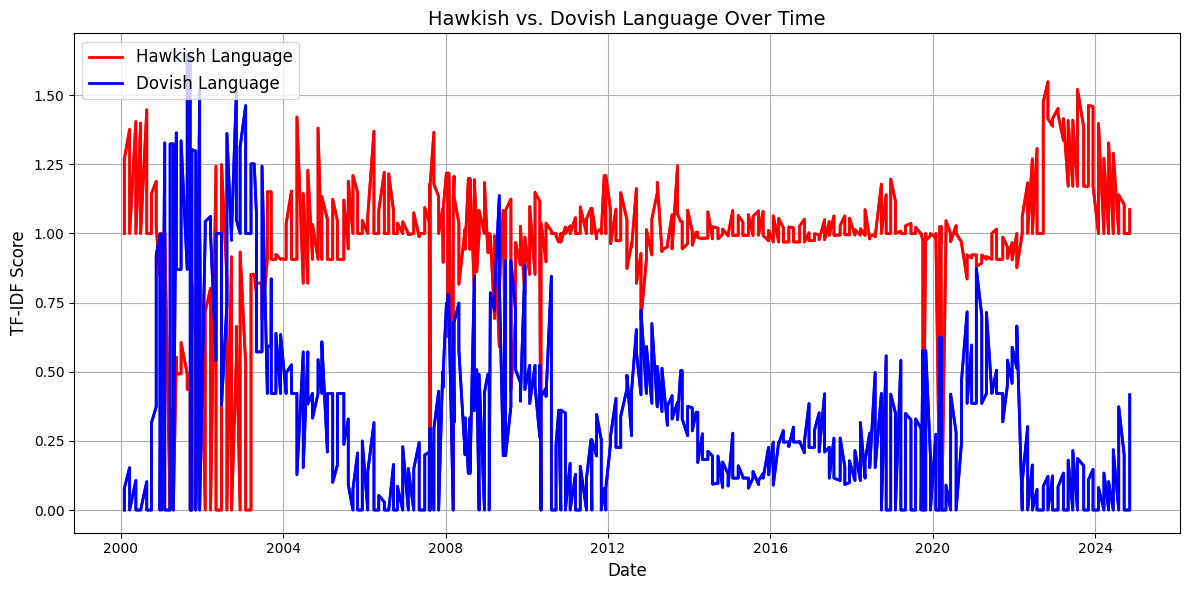

In [27]:
# Aggregate hawkish and dovish TF-IDF scores
tfidf_features['Hawkish_Score'] = tfidf_features[hawkish_keywords].sum(axis=1)
tfidf_features['Dovish_Score'] = tfidf_features[dovish_keywords].sum(axis=1)

# Plot hawkish vs. dovish language over time
plt.figure(figsize=(12, 6))

# Plot the hawkish and dovish scores, and store the line objects
hawkish_line = plt.plot(df['Date'], tfidf_features['Hawkish_Score'], label='Hawkish Language', color='red', lw=2)[0]
dovish_line = plt.plot(df['Date'], tfidf_features['Dovish_Score'], label='Dovish Language', color='blue', lw=2)[0]

# Add titles and labels
plt.title('Hawkish vs. Dovish Language Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)

# Show the grid for better readability
plt.grid(True)

# Manually set the legend using the line objects
plt.legend(handles=[hawkish_line, dovish_line], loc='upper left', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\yunus\AppData\Local\Temp\ipykernel_10756\1826645179.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_colors = plt.cm.get_cmap('tab10', len(avg_tfidf_over_time.columns)).colors


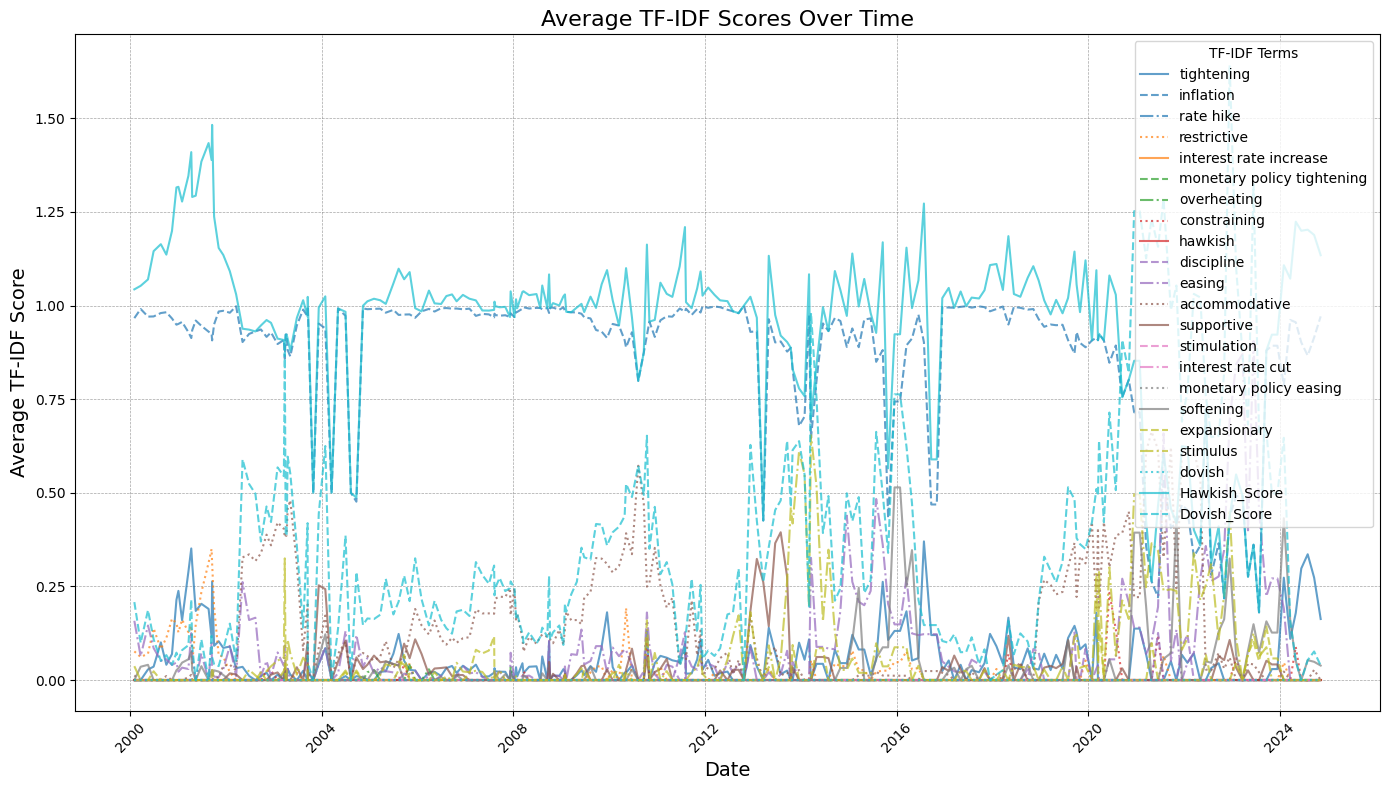

In [28]:
# Compute average TF-IDF scores over time
avg_tfidf_over_time = tfidf_features.groupby('Date').mean()

# Define custom colors and line styles
custom_colors = plt.cm.get_cmap('tab10', len(avg_tfidf_over_time.columns)).colors
line_styles = ['-', '--', '-.', ':']

# Create the plot
plt.figure(figsize=(14, 8))

# Plot each TF-IDF term as a line
for idx, column in enumerate(avg_tfidf_over_time.columns):
    plt.plot(
        avg_tfidf_over_time.index,
        avg_tfidf_over_time[column],
        label=column,
        color=custom_colors[idx % len(custom_colors)],
        linestyle=line_styles[idx % len(line_styles)],
        linewidth=1.5,
        alpha=0.7
    )

# Add titles and labels
plt.title('Average TF-IDF Scores Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average TF-IDF Score', fontsize=14)

# Add grid lines
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Add legend inside the plot
plt.legend(title='TF-IDF Terms', loc='upper right', fontsize=10, frameon=True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442 entries, 441 to 0
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        442 non-null    datetime64[ns]
 1   Release Date                413 non-null    object        
 2   Type                        442 non-null    object        
 3   Text                        442 non-null    object        
 4   Sentiment Score             442 non-null    float64       
 5   Sentiment Category          442 non-null    object        
 6   FinBERT Sentiment           442 non-null    object        
 7   FinBERT Score               442 non-null    float64       
 8   Average Sentiment Score     442 non-null    float64       
 9   Hawkish_Count               442 non-null    int64         
 10  Dovish_Count                442 non-null    int64         
 11  Hawkish_to_Dovish_Ratio     442 non-null    float64       
 12 

In [30]:
# Rename column
df.rename(columns={'Release Date': 'Announcement Date', 'Date':'Release Date'}, inplace=True)

In [31]:
# Drop the second 'Date' column by using duplicated to find the duplicate
df = df.loc[:, ~df.columns.duplicated(keep='first')]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442 entries, 441 to 0
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Release Date                442 non-null    datetime64[ns]
 1   Announcement Date           413 non-null    object        
 2   Type                        442 non-null    object        
 3   Text                        442 non-null    object        
 4   Sentiment Score             442 non-null    float64       
 5   Sentiment Category          442 non-null    object        
 6   FinBERT Sentiment           442 non-null    object        
 7   FinBERT Score               442 non-null    float64       
 8   Average Sentiment Score     442 non-null    float64       
 9   Hawkish_Count               442 non-null    int64         
 10  Dovish_Count                442 non-null    int64         
 11  Hawkish_to_Dovish_Ratio     442 non-null    float64       
 12 

In [33]:
# Save to CSV
df.to_csv('FOMC-Statement-NLP.csv')
print("Data saved to FOMC-Statement-NLP.csv")

Data saved to FOMC-Statement-NLP.csv


In [34]:
# End of the script